# Predicting the Outcome of the Freedom of Information Act Requests

## The problem

In this project we are interested in predicting the outcome of the Freedom of Information Act Requests for News Media. Securities and Exchange Commission made their data publicly available and we are using the data from 2014 to 2016.

For now we only try to predict if a request will be granted or denied, so this is a binary classification problem.

We start with loading the packages we will use for this project

In [1]:
## load packages 
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import numpy as np
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 
from sklearn import linear_model
from sklearn.metrics import recall_score, accuracy_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns; sns.set()
# import warnings
# warnings.filterwarnings('ignore')
%matplotlib inline


Then we load the data from 2014 to 2016 

In [2]:
df_2014= pd.DataFrame.from_csv('foia2014.csv')
df_2015 = pd.DataFrame.from_csv('foia2015.csv')
df_2016= pd.DataFrame.from_csv('foia2016.csv')
df=pd.concat([ df_2014, df_2015, df_2016])
df.head(5)

,requester_name,organization,requester_category,request_description,requested_date,received_date,request_status,closed_date,final_disposition
request_id,,,,,,,,,
14-00001-CHAI,b6,NaN,Other,b6,2013-11-15,2013-11-15,Closed,2013-11-21,Other Reasons
14-00002-CHAI,"Hess, James",The Accurso Law Firm,Commercial Organization,Exhibit 2.2(3) Advance Auto Parts Inc 10-K Ann...,2013-11-21,2013-11-21,Closed,2013-12-03,Other Reasons
14-00003-CHAI,"Husting, Craig",PSRS/PEERS,Other,suspected terrorist links,2013-12-11,2013-12-23,Closed,2014-01-06,Other Reasons
14-00004-CHAI,"Boucher, Raymond",KBSS,Commercial Organization,Chevron Corporation,2013-12-30,2013-12-30,Closed,2014-01-02,Other Reasons
14-00005-CHAI,"Patterson, James",NaN,Other,Newsletter Highlights and Lowlights of Corpora...,2014-01-29,2014-01-29,Closed,2014-02-06,Other Reasons


Let's check the possible values of request status and final disposition.

In [3]:
df.request_status.value_counts()

Closed                 45766
Referral Request         210
Perfected                 59
Documents Added           44
Assigned                  38
On Hold-Other             31
Amended                    4
On Hold-Fee Related        2
Name: request_status, dtype: int64

In [4]:
df.final_disposition.value_counts()

Other Reasons             32307
Granted in full            9210
Denied in full             2603
Granted/Denied in Part     1657
Name: final_disposition, dtype: int64

We are only interested in the requests where 

1) The request status is Closed

2) The request is Granted in full or Denied in full

3) The request category is News Media


In [5]:
# Keep only the closed cases
df= df[df.request_status == 'Closed']

# Keep only granted and denied cases
df= df[ (df['final_disposition']=='Granted in full') | (df['final_disposition']=='Denied in full')]

# Keep only the requests from news media category
df= df[ (df['requester_category']=='News Media')]


We also remove the requests with description 'b6'

In [6]:
# Remove any request with description or name as b6
df= df[(df.request_description != 'b6') & (df.requester_name != 'b6')]


We create separate columns for the request month and the request year and create a new column for final disposition where if the request is granted, the value would be 1 and if the request is denied, the value would be 0.

In [7]:
# Create a binary column named actual for granted=1 and denied=0
df['actual']=0
df.loc[(df['final_disposition']=='Granted in full'),'actual']=1

# convert requested date to datetime and make separate month and year columns
df.loc[:,'requested_date']=pd.to_datetime(df['requested_date'])
df.loc[:,'req_month'] = df['requested_date'].dt.month
df.loc[:,'req_year'] = df['requested_date'].dt.year
del df['requested_date']
del df['closed_date']
del df['received_date']
del df['request_status']
del df['requester_category']

We removed the information on the received date and the closed date since these features cannot be used for our predictions. The requester will not have this information at the time of submitting a request.

Let's check if we have any missing values

In [8]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
organization,7,0.003964
req_year,0,0.000000
req_month,0,0.000000
actual,0,0.000000
final_disposition,0,0.000000
request_description,0,0.000000
requester_name,0,0.000000


Very small part of the data has missing values, so we could just remove those.

In [9]:
df=df.dropna()

In [10]:
df.head()

,requester_name,organization,request_description,final_disposition,actual,req_month,req_year
request_id,,,,,,,
14-00079-FOIA,"Zibel, Alan",Wall Street Journal,SEC Chairman Mary Jo White's official calendar...,Granted in full,1,10,2013
14-00272-FOIA,"Gavin, J. Patrick",SECProbes.com,Green Dot Corporation,Denied in full,0,10,2013
14-00278-FOIA,"Gavin, J. Patrick",SECProbes.com,M&T Bank Corp,Denied in full,0,10,2013
14-00281-FOIA,"Gavin, J. Patrick",SECProbes.com,Pall Corporation,Granted in full,1,10,2013
14-00282-FOIA,"Gavin, J. Patrick",SECProbes.com,Panera Bread Company,Denied in full,0,10,2013


We will make our predictions using mainly the request description, so we first remove the requests where the request description is only numbers

In [11]:
# In the request description, keep the words with alphabetic chars only

corpusall = df['request_description'].values # np array of descriptions
flag=[]  
for i in range(len(corpusall)):
    x = corpusall[i].split(' ')
    y= [ word for word in x if word.isalpha()] # for each description, keeps only the words with alpha chars
    
    # flags if at least one word is only alpha chars. flag is a boolean list.
    if y: 
        flag.append(True)
    else: 
        flag.append(False)
        
# clean data with only alphabetic char request description 
df=df[flag]


# Splitting the data

We now split the data set into training and test sets. We pick 75% of the data set as the training set.

In [12]:
# split the data into training and test data 
train, test = train_test_split(df, train_size=0.75, test_size=0.25, random_state=0)

# Feature Engineering

We are trying to create new features using the request descriptions where each word (or n-gram) will be a feature. For that we need to remove the words with numbers in the training set and we create a list of requests.

In [13]:
# for the training set, make a list of the descriptions with only alphabetical words
corpus = train['request_description'].values
description_list=[]
for line in corpus:
    x = line.split(' ')
    y= [ word for word in x if word.isalpha()]
    if y:
        description = ' '.join(y)
        description_list.append(description)

We remove the stopwords from these request descriptions, use a stemmer and then create n-grams with corresponding tfidf scores. We only create unigrams and bigrams.

In [14]:
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        stems.append(PorterStemmer().stem(item))
    return stems

# define stop words
my_additional_stop_words=[] # could define corpus specific stop words
stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words) # all the stop words

#tfidf vectorizer, tokenize, use the stop words, 1-grams and 2-grams
vectorizer = TfidfVectorizer(tokenizer=tokenize, stop_words=stop_words, ngram_range=(1,2))

# sparse matrix with the scores of the words for each request
tfidf_result = vectorizer.fit_transform(description_list)

# clean up feature names
features= [word.encode('ascii', 'ignore') for word in vectorizer.get_feature_names()]

# np array with the scores of the words for each request
tfidf_arr =np.asarray(tfidf_result.toarray())

# scores np array for each n-gram 
scores = tfidf_arr.sum(axis=0)

# np array indicator matrix
req_desc_ind_train=tfidf_arr.copy()
req_desc_ind_train[req_desc_ind_train>0]=1

We sort the tfidf scores and select the 300 highest scored features.

In [15]:
# sort the scores  
sorted_scores = sorted(scores, reverse=True)
sorted_indices= [b[0] for b in sorted(enumerate(scores),key=lambda i:i[1], reverse=True)]

In [16]:
# pick the highest scored 300 features with their indices
numfeatures = 300

bestfeatures=[]
bestindices=[]
for i in sorted_indices[:numfeatures]:
    bestfeatures.append(features[i])
    bestindices.append(i)


For the test set, we find the n-grams and create the indicator matrix for the selected feature vector.

In [17]:
# for the test set, find the indicator matrix for request descriptions
size_test= test.shape[0]
req_desc_ind_test =np.zeros((size_test,numfeatures));

for i in range(size_test):
    string=test["request_description"].values[i]
    vect = CountVectorizer(ngram_range=(1,2))
    vect.fit([string])    
    wlist=[word.encode('ascii', 'ignore') for word in vect.get_feature_names()]
    for word in wlist:
        if word.lower() in bestfeatures:
            req_desc_ind_test[i][bestfeatures.index(word.lower())]=1
            

If we would like to use features other than the selected 300 n-grams, we combine them in the feature vector. For evaluating the model, we create a column for predictions. For now we will only use the n-grams and the requested month 

In [18]:
# combine all feature matrices for training and test sets
# binary values from categorical features
# features from requested month, year and request description

y_train = train['actual']
y_test = test['actual']
preds = test[['actual']].copy()
X_train_features=pd.concat([pd.get_dummies(train['req_month']),pd.DataFrame(req_desc_ind_train[:,bestindices], columns=bestfeatures, index=train.index)], axis=1, join='inner')
X_test_features=pd.concat([pd.get_dummies(test['req_month']),(pd.DataFrame(req_desc_ind_test, columns=bestfeatures, index=test.index))], axis=1, join='inner')


# The Model

Let's try the logistic regression model with L2 regularization.

In [19]:
logreg = linear_model.LogisticRegression(C=1,penalty='l2',class_weight='balanced')
logreg.fit(X_train_features.values, y_train.values)
Zlogreg = logreg.predict(X_test_features.values)
preds['prediction']=Zlogreg

In [20]:
def plot_confusion_matrix(y_true, y_predicted, labels=None):

    cm = confusion_matrix(y_true, y_predicted)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.round(cm,2)
    labels = labels or range(len(cm))
    acc = accuracy_score(y_true, y_predicted)
    rec = recall_score(y_true, y_predicted)
    precision = precision_score(y_true, y_predicted)
    plt.figure(dpi=80)
    sns.heatmap(cm, xticklabels=['Denied','Granted'], yticklabels=['Denied','Granted'],
    annot=True, fmt="g", cmap="Reds",annot_kws={"size": 18})
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14)
    plt.yticks(rotation="horizontal") 
    plt.title("Accuracy: {:.2f}\nprecision: {:.2f}, recall: {:.2f}".format(acc, precision, rec))
    return

[ 0.875       0.90686275  0.81773399]
             precision    recall  f1-score   support

          0       0.87      0.97      0.91       282
          1       0.90      0.67      0.77       126

avg / total       0.88      0.88      0.87       408



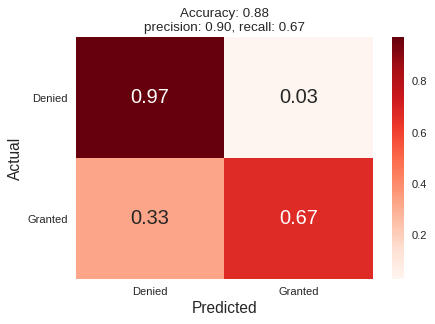

In [21]:
print(cross_val_score(logreg, X_train_features.values, y_train.values))
plot_confusion_matrix(preds['actual'],preds['prediction'],labels=None)
print(classification_report(preds['actual'],preds['prediction']))
plt.show()

In [22]:
preds[:10]

,actual,prediction
request_id,,
16-03112-FOIA,1,1
15-02110-FOIA,1,1
15-02726-FOIA,1,1
14-05473-T,1,0
14-02235-FOIA,0,0
15-06694-T,0,0
16-03179-FOIA,1,1
16-03508-T,0,0
16-01562-T,0,0


# Positive and Negative Features

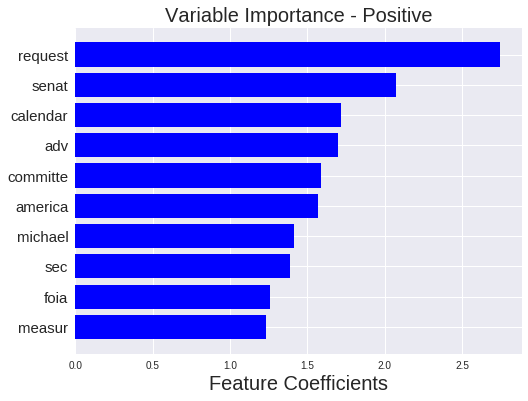

In [23]:
feature_importance = logreg.coef_[0]
top =0  
dep=10
sorted_idx = np.argsort((feature_importance))
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(1,figsize=(8, 6))
dep = len(pos)-dep
top = len(pos)-top
plt.barh(pos[dep:top], feature_importance[sorted_idx][dep:top], align='center', color='b')
plt.yticks(pos[dep:top], np.asanyarray(X_train_features.columns.values.tolist())[sorted_idx][dep:top], fontsize=15)
plt.xlabel('Feature Coefficients', fontsize=20)
plt.title('Variable Importance - Positive', fontsize=20)

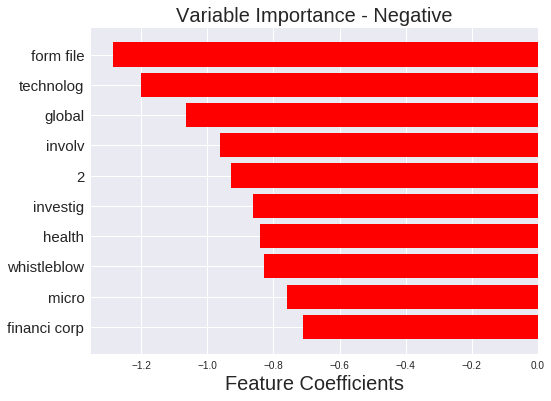

In [24]:
feature_importance = logreg.coef_[0]
top =0    
dep=10
sorted_idx = np.argsort(-feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(8, 6))
dep = len(pos)-dep
top = len(pos)-top
plt.barh(pos[dep:top], feature_importance[sorted_idx][dep:top], align='center', color='r')
plt.yticks(pos[dep:top], np.asanyarray(X_train_features.columns.values.tolist())[sorted_idx][dep:top], fontsize=15)
plt.xlabel('Feature Coefficients', fontsize=20)
plt.title('Variable Importance - Negative', fontsize=20)
plt.show()

# Learning Curve

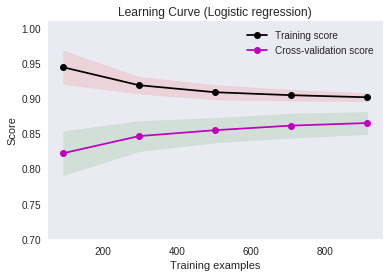

In [25]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="k",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="m",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


X, y =X_train_features.values, y_train.values
cv = ShuffleSplit(n_splits=100, test_size=0.25, random_state=0)

title = "Learning Curve (Logistic regression)"
plot_learning_curve(logreg, title, X, y, ylim=(0.7, 1.01), cv=cv,n_jobs=4)
plt.show()
